In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import requests
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

pd.set_option('display.max_rows',999)
warnings.filterwarnings("ignore")
#import unicodedata
#from io import BytesIO
#import gzip

In [3]:
os.chdir('C:\\Users\\Franco\\Python\\CAF')

In [4]:
distances = pd.read_excel('files/distances.xlsx', index_col = 0)

In [5]:
cwpops = pd.read_excel('files/cwpops.xlsx', index_col = [0,1])

### Acomodar el tema 'Distances' a km

In [6]:
distances['Distance2'] = distances['Distance']

In [7]:
distances.loc[(distances['Distance'].str.contains(' ft| m')),'Distance2'] = '0 km'

In [8]:
distances['distance_km'] = distances['Distance2'].apply(lambda x: x.replace(' km',''))

In [9]:
distances['distance_km'] = distances['distance_km'].astype('float')

In [10]:
del distances['Distance2']

### Obtengo latitudes y longitudes de las ciudades

In [11]:
latlongs = distances[['Country','City A','Point A']].rename(columns = {'Point A':'latlong','City A':'City'}).drop_duplicates('City').set_index(['Country','City']).dropna()
latlongs[['lat','long']] = latlongs['latlong'].apply(lambda x: pd.Series(x.split(','))).astype(float)
latlongs = latlongs.drop('latlong', axis = 1)

### Joineo con latlongs y creo GeoDataFrame

In [12]:
cwpops = cwpops.join(latlongs)
cwpops = gpd.GeoDataFrame(cwpops, geometry=gpd.points_from_xy(cwpops.long, cwpops.lat))

## Generar 'Parsed time in traffic' 

In [13]:
distances['dit_elementos'] = distances['Duration in traffic'].apply(lambda x: len(re.split('day|hour|mins|seconds',x)))

In [14]:
distances['duration_traffic'] = np.nan

for i, row in distances.iterrows():
    if 'second' in row['Duration in traffic']:
        distances.loc[i,'duration_traffic']  = float(0)
    elif 'mins' in row['Duration in traffic'] and 'hour' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic']  = float('0.'+row['Duration in traffic'].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic']  = float('0.0'+row['Duration in traffic'].replace(' mins',''))*100/60
    elif 'hour' in row['Duration in traffic'] and 'day' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].split(' hour ')[1].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.0'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
    elif 'day' in row['Duration in traffic']:
        a = re.split(' day | hour | mins',row['Duration in traffic'])
        if len(a[2]) > 1:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.'+a[2])*100/60
        else:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.0'+a[2])*100/60

### Calculo de congestión promedio

Mantengo sólo ciudades que se encuentran a menos de 12 horas de la ciudad objetivo

In [15]:
distances = distances.replace('NAN', np.nan)

In [16]:
cerca = distances.loc[(distances['duration_traffic'] <= 12),:]

In [17]:
#Gráficos de promedio de kms recorridos por hora
"""
promedios = pd.DataFrame(data=cerca.groupby(['Country' , 'City A'])['kms_hora'].mean())

sns.catplot(x="City A", y="kms_hora" ,col="Country", col_wrap=4,

                data=promedios.reset_index(),

                kind="bar", height=2.5, aspect=.8)

sns.set_theme()
g = sns.barplot(x="City A", y="kms_hora", data=promedios.loc['Mexico',:].reset_index(),color="b")
labels=promedios.loc['Mexico',:].reset_index()['City A']
g.set_xticklabels(labels=labels,rotation='vertical')
"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-17-afd26f0f07af>, line 14)

Ahora agrego ciudades con masa salarial (% del total del país) mayor a la mediana del país

In [19]:
citywage = pd.DataFrame(cwpops.loc[:,'estimated_citywage'])

a = citywage.groupby('Country').sum('estimated_citywage')
a.rename(columns={'estimated_citywage':'country_wage'},inplace=True)

citywage = a.join(citywage,how='inner')

citywage['wage_ratio'] = citywage['estimated_citywage'] / citywage['country_wage']

citywage.dropna(subset=['wage_ratio'],inplace=True)

In [20]:
a = pd.DataFrame(citywage.loc[:,'wage_ratio'].groupby('Country').median('wage_ratio'))

a.rename(columns={'wage_ratio':'median_wr'},inplace=True)

In [21]:
citywage = a.join(citywage,how='inner')

In [22]:
mercados_target = citywage.loc[(citywage['wage_ratio']>citywage['median_wr']),:]

Ahora filtro mi base de distancias dejando solo los mercados target dentro de las city B

In [23]:
mercados_target.reset_index(inplace=True)
mercados_target.rename(columns={'City':'City B'},inplace=True)
mercados_target.drop(columns=['Country','median_wr','country_wage'],inplace=True)

In [24]:
cerca_mercado = cerca.merge(mercados_target,on='City B', how='inner',validate='m:1',)

In [25]:
cerca_mercado.loc[(cerca_mercado['City A']=='Bahia Blanca-Cerri'),:]

,Country,City A,Point A,City B,Point B,Distance,Duration,Duration in traffic,parsed_duration,distance_km,dit_elementos,duration_traffic,estimated_citywage,wage_ratio
0,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Partidos del GBA,"-34.652,-58.547",629.8 km,7 h 31 min,7 hour 20 mins,7.516667,629.8,3,7.333333,9.714442e+07,0.494511
1,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Partidos del GBA,"-37.387311,-68.9227816",704.1 km,8 h 27 min,8 hour 30 mins,8.450000,704.1,3,8.500000,9.714442e+07,0.494511
30,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Ciudad de Buenos Aires,"-34.6075682,-58.4370894",633.8 km,7 h 36 min,7 hour 10 mins,7.600000,633.8,3,7.166667,3.036077e+07,0.154551
49,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Cordoba,"-31.381,-64.216",952.1 km,10 h 22 min,11 hour 10 mins,10.366667,952.1,3,11.166667,8.675468e+06,0.044162
74,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran La Plata,"-34.9206797,-57.9537638",627.7 km,7 h 41 min,7 hour 20 mins,7.683333,627.7,3,7.333333,1.481585e+06,0.007542
91,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Mar del Plata-Batan,"-37.991,-57.589",459.6 km,5 h 19 min,5 hour 10 mins,5.316667,459.6,3,5.166667,4.604421e+06,0.023439
106,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Neuquen-Plottier,"-38.943,-68.11",537.7 km,6 h 49 min,6 hour 40 mins,6.816667,537.7,3,6.666667,2.590881e+06,0.013189
118,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Parana,"-31.7330145,-60.5298511",983.1 km,11 h 43 min,12 hour 0 mins,11.716667,983.1,3,12.000000,1.534617e+06,0.007812
140,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Rosario,"-32.916,-60.719",759.6 km,9 h 15 min,9 hour 50 mins,9.250000,759.6,3,9.833333,8.235352e+06,0.041922
165,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Gran Santa Fe,"-31.617,-60.728",924.7 km,10 h 59 min,11 hour 50 mins,10.983333,924.7,3,11.833333,2.535846e+06,0.012909


In [26]:
cerca_mercado['kms_hora'] = cerca_mercado['distance_km'] / cerca_mercado['duration_traffic']

In [32]:
cerca_mercado.head()

,Country,City A,Point A,City B,Point B,Distance,Duration,Duration in traffic,parsed_duration,distance_km,dit_elementos,duration_traffic,estimated_citywage,wage_ratio,kms_hora
0,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Partidos del GBA,"-34.652,-58.547",629.8 km,7 h 31 min,7 hour 20 mins,7.516667,629.8,3,7.333333,9.714442e+07,0.494511,85.881818
1,Argentina,Bahia Blanca-Cerri,"-38.723,-62.279",Partidos del GBA,"-37.387311,-68.9227816",704.1 km,8 h 27 min,8 hour 30 mins,8.450000,704.1,3,8.500000,9.714442e+07,0.494511,82.835294
2,Argentina,Ciudad de Buenos Aires,"-34.6075682,-58.4370894",Partidos del GBA,"-34.652,-58.547",14.2 km,32 min,24 mins,0.533333,14.2,2,0.400000,9.714442e+07,0.494511,35.500000
3,Argentina,Concordia,"-31.383,-58.024",Partidos del GBA,"-34.652,-58.547",433.4 km,4 h 50 min,4 hour 40 mins,4.833333,433.4,3,4.666667,9.714442e+07,0.494511,92.871429
4,Argentina,Gran Cordoba,"-31.381,-64.216",Partidos del GBA,"-34.652,-58.547",702.8 km,7 h 19 min,7 hour 10 mins,7.316667,702.8,3,7.166667,9.714442e+07,0.494511,98.065116


Ahora tengo que crear las distancias x hora recorridas promedio de cada ciudad para 3 6 9 y 12 horas max

In [314]:
mylist = [3,6,9,12]
cm = pd.DataFrame(index = cwpops.index)

for c in cm:
    for i in mylist:
        a = cerca_mercado.set_index(['Country','City A'])
        a = a.loc[(cm.index.unique()[0])&(a['duration_traffic'] < i),'kms_hora']

        a = a.drop(cm.columns[0:-1],axis=1)



        cm['kmxhora_{}horas'.format(i)] = cm.join(a,how='inner')

Point A            City B  \
Country   City                                                                
Argentina Bahia Blanca-Cerri              -38.723,-62.279  Partidos del GBA   
          Bahia Blanca-Cerri              -38.723,-62.279  Partidos del GBA   
          Ciudad de Buenos Aires  -34.6075682,-58.4370894  Partidos del GBA   
          Concordia                       -31.383,-58.024  Partidos del GBA   
          Gran Cordoba                    -31.381,-64.216  Partidos del GBA   
...                                                   ...               ...   
Uruguay   San Jose De Mayo        -34.3396765,-56.7138662           Artigas   
          Santa Lucia             -34.4550929,-56.3893012           Artigas   
          Tacuarembo                     -32.166667,-55.5           Artigas   
          Treinta Y Tres                     -33.0,-54.25           Artigas   
          Young                   -32.6995318,-57.6341992           Artigas   

                                                  Point B  Distance  \
Country   City                                                        
Argentina Bahia Blanca-Cerri              -34.652,-58.547  629.8 km   
          Bahia Blanca-Cerri       -37.387311,-68.9227816  704.1 km   
          Ciudad de Buenos Aires          -34.652,-58.547   14.2 km   
          Concordia                       -34.652,-58.547  433.4 km   
          Gran Cordoba                    -34.652,-58.547  702.8 km   
...                                                   ...       ...   
Uruguay   San Jose De Mayo        -30.6170756,-56.9373451  569.5 km   
          Santa Lucia             -30.6170756,-56.9373451  601.5 km   
          Tacuarembo              -30.6170756,-56.9373451  320.9 km   
          Treinta Y Tres          -30.6170756,-56.9373451  547.2 km   
          Young                   -30.6170756,-56.9373451  351.4 km   

                                    Duration Duration in traffic  \
Country   City                                                     
Argentina Bahia Blanca-Cerri      7 h 31 min      7 hour 20 mins   
          Bahia Blanca-Cerri      8 h 27 min      8 hour 30 mins   
          Ciudad de Buenos Aires      32 min             24 mins   
          Concordia               4 h 50 min      4 hour 40 mins   
          Gran Cordoba            7 h 19 min      7 hour 10 mins   
...                                      ...                 ...   
Uruguay   San Jose De Mayo        6 h 54 min      6 hour 50 mins   
          Santa Lucia             7 h 21 min      7 hour 20 mins   
          Tacuarembo              5 h 20 min      5 hour 20 mins   
          Treinta Y Tres           7 h 3 min      7 hour 10 mins   
          Young                   4 h 28 min      4 hour 30 mins   

                                  parsed_duration  distance_km  \
Country   City                                                   
Argentina Bahia Blanca-Cerri             7.516667        629.8   
          Bahia Blanca-Cerri             8.450000        704.1   
          Ciudad de Buenos Aires         0.533333         14.2   
          Concordia                      4.833333        433.4   
          Gran Cordoba                   7.316667        702.8   
...                                           ...          ...   
Uruguay   San Jose De Mayo               6.900000        569.5   
          Santa Lucia                    7.350000        601.5   
          Tacuarembo                     5.333333        320.9   
          Treinta Y Tres                 7.050000        547.2   
          Young                          4.466667        351.4   

                                  duration_traffic  estimated_citywage  \
Country   City                                                           
Argentina Bahia Blanca-Cerri              7.333333        9.714442e+07   
          Bahia Blanca-Cerri              8.500000        9.714442e+07   
          Ciudad de Buenos Aires          0.400000        

In [99]:
cm = pd.DataFrame(np.nan ,index = cerca_mercado.index.unique(),columns=['dist_3horas','dist_6horas','dist_9horas','dist_12horas'])

mylist = [3,6,9,12]

cerca_mercado = cerca_mercado.rename(columns={'City A':'City'}).set_index(['Country','City'])

In [114]:
for i,r in cm.iterrows():
    p = cerca_mercado.loc[i,:]
    for e in mylist:
        cm.loc[i,'dist_{}horas'.format(e)] = p.loc[(p['duration_traffic'] <= e),'kms_hora'].mean()

In [130]:
cerca_mercado.query('(Country == "Argentina" and City == "Bahia Blanca-Cerri") and duration_traffic <= 9').loc[:,'kms_hora'].mean()

85.39326914282047

In [127]:
cm

dist_3horas  dist_6horas  \
Country    City                                                               
Argentina  Bahia Blanca-Cerri                              NaN    88.954839   
           Ciudad de Buenos Aires                    51.950000    80.806338   
           Concordia                                       NaN    87.946215   
           Gran Cordoba                                    NaN    87.026437   
           Corrientes                                44.800000    44.800000   
           Gran La Plata                             71.909091    87.024264   
           Mar del Plata-Batan                             NaN    96.942171   
           Gran Mendoza                              77.485714    77.485714   
           Neuquen-Plottier                                NaN    75.031579   
           Gran Parana                               76.759615    86.670530   
           Posadas                                         NaN    88.392547   
           Rawson-Trelew                                   NaN    71.925000   
           Gran Resistencia                          47.357143    47.357143   
           Rio Cuarto                                91.720000    83.579824   
           Gran Rosario                              94.637143    96.000677   
           Gran San Juan                                   NaN          NaN   
           San Luis-El Chorrillo                           NaN    80.167500   
           San Nicolas-Villa Constitucion            91.184606    91.992162   
           San Rafael                                      NaN    82.324138   
           Gran Santa Fe                             77.970000    89.765518   
           Santa Rosa-Toay                                 NaN    93.171429   
           Tandil                                    85.350000    87.595174   
           Viedma-Carmen de Patagones                92.666667    92.666667   
           Partidos del GBA                          64.042735    82.340331   
           Gran Catamarca                            79.941176    79.401218   
           Jujuy-Palpala                             68.181818    78.289455   
           La Rioja                                        NaN    81.791102   
           Salta                                           NaN    86.958571   
           Santiago del Estero-La Banda              74.307692    81.680629   
           Gran Tucuman-Tafi Viejo                   80.050000    83.596429   
           Formosa                                   75.484286    75.484286   
           Rio Gallegos                                    NaN          NaN   
Bolivia    Cercado/Cochabamba                              NaN    55.442308   
           Oropeza                                         NaN    54.326374   
           Cercado/Oruro                             74.400000    63.736000   
           Tomas Frías/Potosí                              NaN    62.533596   
           Quillacollo                               34.200000    48.056000   
           Sucre                                     58.162500    58.162500   
           Vaca Diez                                       NaN          NaN   
           Pedro Domingo Murillo/La Paz y el Alto    74.400000    68.091667   
           Cercado/Tarija                                  NaN    58.016667   
           Obispo Santisteban/Montero                56.700000    56.700000   
           Cercado/Trinidad                                NaN          NaN   
           Andrés Ibañez/Santa Cruz de la Sierra           NaN          NaN   
Brasil     Belo Horizonte                                  NaN    81.937500   
           Rio de Janeiro                                  NaN    86.875446   
           Sao Paulo                                       NaN    92.250000   
           Belem                                           NaN          NaN   
           Brasilia                                        NaN          NaN   
           Alagoinhas 

### calculo cutoff de tiempo

In [14]:
def get_wages_from_cutoff(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['duration_traffic'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [15]:
def get_countryshare_from_cutoff(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [16]:
shares_cutoff = pd.DataFrame(index = cwpops.index)
shares_cutoff['index1'] = shares_cutoff.index

In [17]:
for i in range(10):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(lambda x: get_countryshare_from_cutoff(x , cutoff = i))

### Calculo cutoff de distancia

In [18]:
def get_wages_from_cutoff_d(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['distance_km'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [19]:
def get_countryshare_from_cutoff_d(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff_d(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [20]:
shares_cutoff_d = pd.DataFrame(index = cwpops.index)
shares_cutoff_d['index1'] = shares_cutoff.index

In [21]:
for i in range(0,1000,100):
    shares_cutoff_d['cutoff_' + str(i)] = shares_cutoff_d['index1'].apply(lambda x: get_countryshare_from_cutoff_d(x , cutoff = i))

### Crear indicador de la relación: distancia/tiempo

In [22]:
shares_cutoff_d.shape

(422, 11)

In [23]:
shares_cutoff.shape

(422, 11)

In [24]:
s = shares_cutoff.join(shares_cutoff_d.iloc[:,1:],how='inner',rsuffix='00')

In [25]:
for i in range(10):
    s['dif_{}'.format(i)] = s['cutoff_{}00'.format(i)] / s['cutoff_{}'.format(i)]

### ver que salio

In [26]:
stack = pd.DataFrame(s.iloc[:,21:].reset_index().set_index(['Country','City']).stack(dropna=False) , columns=['dif'])
stack = stack.reset_index().set_index(['Country','City'])
stack.columns = ['hours' , 'dif']

In [27]:
#stack.xs('Bahia Blanca-Cerri',level=1,drop_level=False)

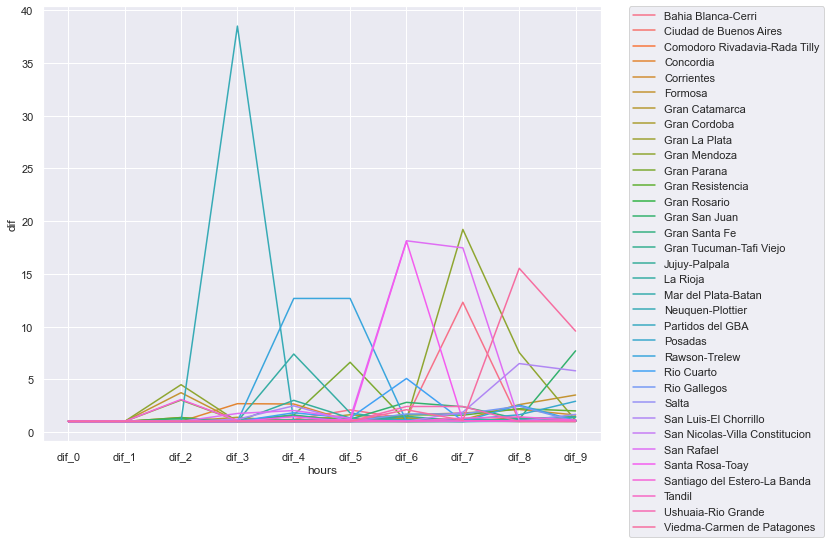

In [28]:
x = stack.loc['Argentina']

sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=x, x="hours", y="dif" , hue = 'City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Creo nueva base para trabajar con las diferencias en el *cutoff* de distancia vs tiempo 

In [29]:
sb = s

In [30]:
for i in range(10):
    sb['dif_{}'.format(i)] = sb['cutoff_{}00'.format(i)] - sb['cutoff_{}'.format(i)]

In [31]:
sb = sb.iloc[:,21:]

In [32]:
sb['sum_dif'] = sb.sum(axis=1)

In [33]:
sb.head()

dif_0  dif_1     dif_2     dif_3  \
Country   City                                                              
Argentina Bahia Blanca-Cerri               0.0    0.0  0.000000  0.000000   
          Ciudad de Buenos Aires           0.0    0.0  0.000000  0.041922   
          Comodoro Rivadavia-Rada Tilly    0.0    0.0  0.000000  0.000000   
          Concordia                        0.0    0.0  0.000000  0.007812   
          Corrientes                       0.0    0.0  0.005708  0.000000   

                                            dif_4     dif_5     dif_6  \
Country   City                                                          
Argentina Bahia Blanca-Cerri             0.003607  0.023439  0.013189   
          Ciudad de Buenos Aires         0.000000  0.000000  0.000000   
          Comodoro Rivadavia-Rada Tilly  0.001011  0.001011  0.000000   
          Concordia                      0.041922  0.021067  0.006858   
          Corrientes                     0.000000  0.004644  0.020721   

                                            dif_7     dif_8     dif_9  \
Country   City                                                          
Argentina Bahia Blanca-Cerri             0.656603  0.055000  0.055342   
          Ciudad de Buenos Aires         0.017904  0.004902  0.004902   
          Comodoro Rivadavia-Rada Tilly  0.000000  0.004773  0.002958   
          Concordia                      0.049870  0.015992  0.006678   
          Corrientes                     0.032364  0.082396  0.070561   

                                          sum_dif  
Country   City                                     
Argentina Bahia Blanca-Cerri             0.807179  
          Ciudad de Buenos Aires         0.069629  
          Comodoro Rivadavia-Rada Tilly  0.009752  
          Concordia                      0.150199  
          Corrientes                     0.216394

### Traigo ciudades intermedias

In [34]:
inter = pd.read_csv('files/cities_int.csv')

In [35]:
inter.sort_values(by=['REGION_UN',
'CONTINENT',
'REGION_WB',
'REGION',   
'SUBREGION',
'COUNTRY',
'COUNTRY_ID',
'MAIN_CITY',
'CITY_ID',],inplace=True)

inter.set_index(['REGION_UN',
'CONTINENT',
'REGION_WB',
'REGION',   
'SUBREGION',
'COUNTRY',
'COUNTRY_ID',
'MAIN_CITY',
'CITY_ID',],inplace=True)

In [36]:
inter.head()

OBJECTID  \
REGION_UN CONTINENT     REGION_WB                 REGION                    SUBREGION COUNTRY      COUNTRY_ID MAIN_CITY  CITY_ID             
Americas  North America Latin America & Caribbean Latin America & the Carib Caribbean Bahamas, The BHS        Nassau     1503        181.0   
                                                                                      Cuba         CUB        Bayamo     3564       1456.0   
                                                                                                              Cienfuegos 3565       1457.0   
                                                                                                              Guantanamo 1861       1454.0   
                                                                                                              Holguin    1863       1461.0   

                                                                                                                                    Id  \
REGION_UN CONTINENT     REGION_WB                 REGION                    SUBREGION COUNTRY      COUNTRY_ID MAIN_CITY  CITY_ID         
Americas  North America Latin America & Caribbean Latin America & the Carib Caribbean Bahamas, The BHS        Nassau     1503      531   
                                                                                      Cuba         CUB        Bayamo     3564     2655   
                                                                                                              Cienfuegos 3565     2783   
                                                                                                              Guantanamo 1861     2132   
                                                                                                              Holguin    1863     3844   

                                                                                                                                   SOVEREIGNT  \
REGION_UN CONTINENT     REGION_WB                 REGION                    SUBREGION COUNTRY      COUNTRY_ID MAIN_CITY  CITY_ID                
Americas  North America Latin America & Caribbean Latin America & the Carib Caribbean Bahamas, The BHS        Nassau     1503     The Bahamas   
                                                                                      Cuba         CUB        Bayamo     3564            Cuba   
                                                                                                              Cienfuegos 3565            Cuba   
                                                                                                              Guantanamo 1861            Cuba   
                                                                                                              Holguin    1863            Cuba   

                                                                                                                                 SOV_A3  \
REGION_UN CONTINENT     REGION_WB                 REGION                    SUBREGION COUNTRY      COUNTRY_ID MAIN_CITY  CITY_ID          
Americas  North America Latin America & Caribbean Latin America & the Carib Caribbean Bahamas, The BHS        Nassau     1503       BHS   
                                                                                      Cuba         CUB        Bayamo     3564       CUB   
                                                                                                              Cienfuegos 3565       CUB   
                                                                                                              Guantanamo 1861       CUB   
                                                                                                              Holguin    1863       CUB   

                                                                                                                                        ADMIN  \
REGION_UN CONTINENT     REGION_WB